# CAPTCHA Data Generation

Here we are generating the training data for a convolutional CAPTCHA recognition and segmentation nets. 

We need to generate a lot of images with labels for file names. We will be using claptcha, a open source python project (https://github.com/kuszaj/claptcha), to generate the images. 

We need two sets, one set of images of just one charecter to train the segmentation net (seg_data). The other set will be 5 charecter CAPTCHAS.

In [1]:
from claptcha import Claptcha
#Add the path to claptcha in PYTHONPATH var in terminal
import glob
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

CAPTCHA_CHARS = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
NOISE = 1
KER_SZ = (32,32)
CAPTCHA_SZ = (200, 72)

### Single Char Data

We will set the size of the captcha to 32x32, the size of the segmentation. Only one char will be generated. We want to use a lot of diffrent fonts to make our nets more general. Claptcha takes .ttf path in the constructor. We will download a bunch of fonts into the font folder and loop though each and generate data using it. 

For chars, we will use all alphanumerics.

In [2]:
fonts = glob.glob("./fonts/*")
print(f"Found {len(fonts)} fonts in ./fonts")
dev_font = fonts[6]
print(f"Testing with font {dev_font[8:]}")

Found 234 fonts in ./fonts
Testing with font Noto Sans ExtraBold Nerd Font Complete.ttf


In [3]:
#Claptcha object takes a function which generates the string for the image
#This function will return a single random alphanumeric
def single_char():
    return random.choice(CAPTCHA_CHARS)
    
print("10 Random Chars:")
out = ""
for i in range(10):
    out += single_char() + "  "
print(out)

10 Random Chars:
c  M  2  w  Y  v  j  a  y  9  


i


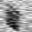

(32, 32, 3)


In [4]:
#Initilizing Claptcha Object for testing
dev_claptcha = Claptcha(single_char, dev_font, size=(32,32), margin=(0,0), noise=NOISE)

label, img = dev_claptcha.image
print(label)
display(img)
print(np.array(img).shape)

Claptcha takes a size and a margin for the output image. If the size is set at 32x32, that is the size of our filter and we can rely on the letter being centered. 

Our segmnetation net has two output classes, 0 if no letter, 1 if a letter in the center of the filter. Thus in our training data we need labeled centered and non centered images. We have the centered images already, but the off center are a little hareder.

We can set the size to be 64x64 with a margin of 16x16. Thus our letter will roughly be bound to the center of the image in a 32x32 box. If we crop this image not on the center, we can get off centered images:

e


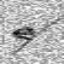

Cropped:


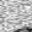

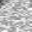

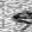

In [5]:
#Initilizing Claptcha Object for testing
dev_claptcha = Claptcha(single_char, dev_font, size=(64,64), margin=(16,16), noise=NOISE)

label, img = dev_claptcha.image
print(label)
display(img)
print("Cropped:")
display(img.crop((0,0,32,32)))
display(img.crop((32,32,64,64)))
display(img.crop((0,16,32,16+32)))

Now we have all the peices for the the segmentation training data. Now we want to keep all this data in ndarrays as that is how we will give it to the net. 

seg_x : (N, 32,32,3)

seg_y : (N, 1)

seg_pos_y : (N, 1)

seg_pos_y stores the labels for centered or not, seg_y is the letter in the CAPTCHA

In [12]:
font_n = 200 #number of samples per font
N = len(fonts) * font_n * 2

x = np.zeros((N,*KER_SZ, 3))
y_label = np.empty((N,), dtype=str)
y_pos = np.zeros((N,))

idx = 0
#Centered images first
print("Generating Centered images:")
for font_i in tqdm (range (len(fonts)), desc="Loading..."):
    font = fonts[font_i]
    for i in range(font_n):
        noise = np.random.rand()
        label, image = Claptcha(single_char, font, size=KER_SZ, margin=(2,2), noise=noise).image
        x[idx,:,:,:] = np.array(image)
        y_label[idx] = label
        y_pos[idx] = 1 #all these are centered
        idx += 1
    

print("Generating non-centered images:")
for font_i in tqdm (range (len(fonts)), desc="Loading..."):
    font = fonts[font_i]
    for i in range(font_n):
        noise = np.random.rand()
        label, image = Claptcha(single_char, font, size=(KER_SZ[0]*2, KER_SZ[1]*2), margin=(KER_SZ[0]/2,KER_SZ[1]/2), noise=NOISE).image
        row_offset = np.random.randint(0, KER_SZ[0])
        col_offset = np.random.randint(0, KER_SZ[1])
        x[idx,:,:,:] = np.array(image.crop((row_offset, col_offset, row_offset+KER_SZ[0], col_offset+KER_SZ[1])))
        y_label[idx] = label
        idx += 1

np.save('data/x_single.npy', x)
np.save('data/y_single_label.npy', y_label)
np.save('data/y_single_pos.npy', y_pos)

Generating Centered images:


Loading...: 100%|█████████████████████████████| 234/234 [00:59<00:00,  3.91it/s]


Generating non-centered images:


Loading...: 100%|█████████████████████████████| 234/234 [01:38<00:00,  2.38it/s]


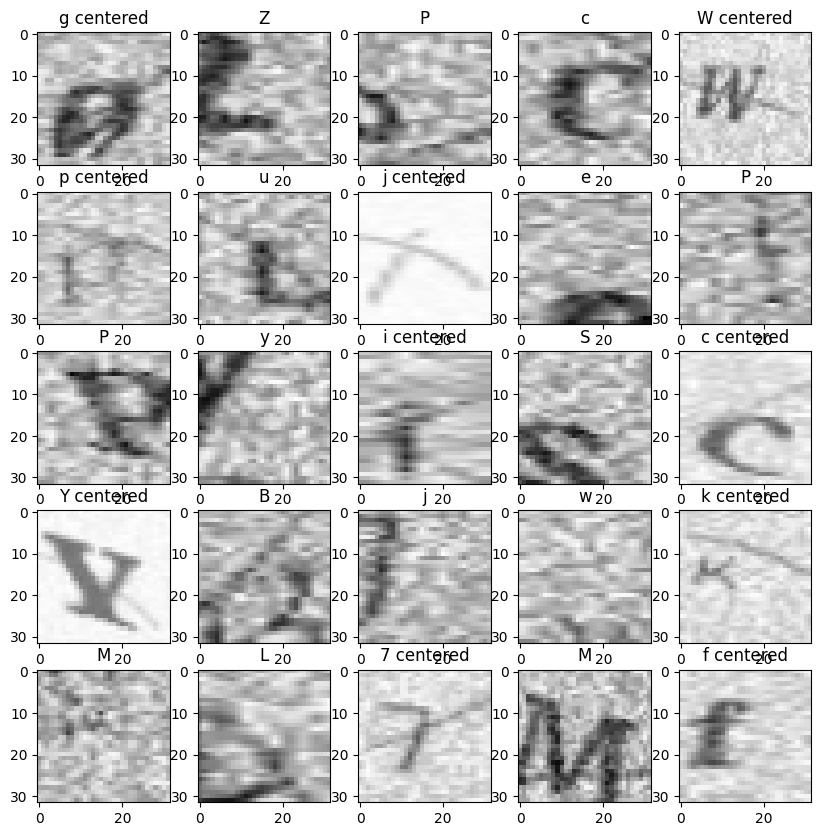

In [13]:
fig, axs = plt.subplots(5,5)
fig.set_size_inches(10,10)

for i in range(5):
    for j in range(5):
        idx = np.random.randint(0, N)
        axs[i,j].imshow(x[idx, :, :, :].astype(int))
        title = y_label[idx]
        if y_pos[idx] == 1:
            title += " centered"
        axs[i,j].set_title(title)
        axs[i,j].set_xticks = []
        axs[i,j].set_yticks = []
    
plt.show()

### Multi Char Data

This will be very similar to the single char. We have to change the source function to return randomized strings. 

In [14]:
def multi_char():
    return ''.join(random.choices(CAPTCHA_CHARS, k=5))

print("five test strings:")
for i in range(5):
    print(multi_char())


five test strings:
Z6BND
5Ts0L
IQngr
5RZZ9
Ny2J0


pjI9S


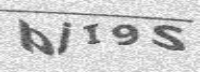

(72, 200, 3)


In [15]:
#Initilizing Claptcha Object for testing
dev_claptcha = Claptcha(multi_char, dev_font, size=CAPTCHA_SZ, margin=(20,20), noise=0.5)
label, img = dev_claptcha.image
print(label)
display(img)
print(np.array(img).shape)

In [16]:
font_n = 200 #number of samples per font
N = len(fonts) * font_n 

x_multi = np.zeros((N,CAPTCHA_SZ[1],CAPTCHA_SZ[0], 3))
y_multi_label = np.empty((N,), dtype=str)

idx = 0
#Centered images first
print("Generating images:")
for font_i in tqdm (range (len(fonts)), desc="Loading..."):
    font = fonts[font_i]
    for i in range(font_n):
        noise = np.random.rand()
        label, image = Claptcha(multi_char(), font, size=CAPTCHA_SZ, margin=(10,10), noise=noise).image
        x_multi[idx,:,:,:] = np.array(image)
        y_multi_label[idx] = label
        idx += 1

np.save('data/x_multi.npy', x_multi)
np.save('data/y_multi.npy', y_multi_label)

Generating images:


Loading...: 100%|█████████████████████████████| 234/234 [11:24<00:00,  2.92s/it]


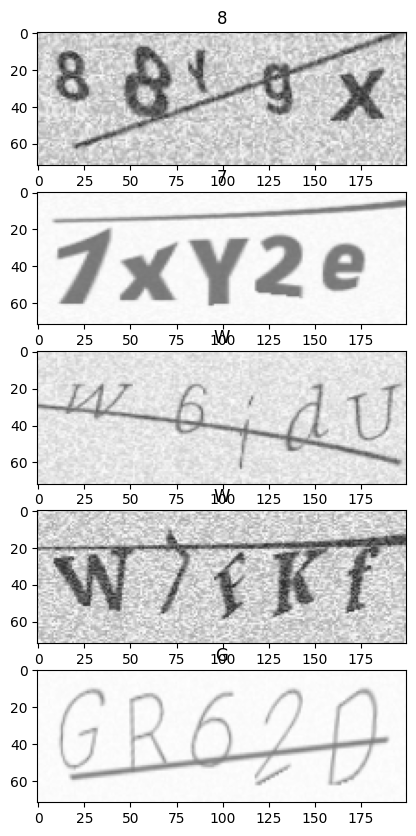

In [17]:
fig, axs = plt.subplots(5,1)
fig.set_size_inches(10,10)

for i in range(5):
    idx = np.random.randint(0, N)
    axs[i].imshow(x_multi[idx, :, :, :].astype(int))
    title = y_multi_label[idx]
    axs[i].set_title(title)
    axs[i].set_xticks = []
    axs[i].set_yticks = []
    
plt.show()